In [1]:
import sys
from pathlib import Path
import pandas as pd
import tarfile
import urllib

def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
metadata = load_metadata()

def extract_eeg():
  eeg_dir = Path("../data/eeg")
  tarball_path = Path("data/eeg.tar.gz")
  if not tarball_path.is_file():
    url = 'https://dl.dropboxusercontent.com/scl/fi/5sina48c4naaxv6uze0fv/eeg.tar.gz?rlkey=r7ec191extynfcm8fy0tsiws5&dl=0'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as eeg_tarball:
      eeg_tarball.extractall()
    
extract_eeg()

metadata

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [2]:
# Add a unique id to each sample
from src.utils.utils import compute_signal_hash

def compute_unique_id(row):
  return str(compute_signal_hash(row))

metadata['unique_id'] = metadata.apply(compute_unique_id, axis=1)

cols = metadata.columns.tolist()
cols = [cols[-1]] + cols[:-1]
metadata = metadata[cols]
metadata

,unique_id,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,db76e9927,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,0e1116d9d,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,8ec6d3c8c,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,662b0bd39,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,ca946aadb,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,368247dd8,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,a7a60ad75,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,97f63909c,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,a5399830b,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [3]:
import dask.dataframe as dd
from src.utils import compute_signal_hash

channel_order = ['Fp1', 'Fp2',
            'F7', 'F3', 'Fz', 'F4', 'F8', 
            'T3', 'C3', 'Cz', 'C4', 'T4', 
            'T5', 'P3', 'Pz', 'P4', 'T6', 
            'O1', 'O2',
          ]

def load_signals(metadata):
  rows = len(metadata)
  eeg_list = []

  for row in range(0,rows):
    sample = metadata.iloc[row]
    f_name = f'data/eeg/{sample.eeg_id}.parquet'
    eeg = pd.read_parquet(f_name)[channel_order]
    eeg_offset = int(sample.eeg_label_offset_seconds)

    eeg['unique_id'] = sample['unique_id']
    eeg = eeg.set_index('unique_id')

    eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]
    eeg_list.append(eeg)

  return dd.concat(eeg_list)

ddf = load_signals(metadata)

In [4]:
df = ddf.compute()
eeg_ids = list(set(df.index))
df

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
unique_id,,,,,,,,,,,,,,,,,,,
db76e9927,-14.780000,-33.049999,-8.910000,-5.600000,-21.650000,1.780000,-26.129999,9.850000,-16.209999,-33.310001,-17.459999,3.22,-5.170000,-14.370000,-13.94,-24.629999,-4.620000,-27.780001,-17.980000
db76e9927,-8.100000,-34.610001,-26.570000,-2.770000,-20.350000,0.660000,-35.130001,13.400000,-16.600000,-36.060001,-17.309999,15.12,-3.140000,-15.580000,-15.91,-25.969999,-1.740000,-28.480000,-20.629999
db76e9927,-3.530000,-34.709999,17.120001,15.570000,-19.110001,-0.770000,-24.709999,30.219999,-8.930000,-32.369999,-23.840000,-2.82,14.670000,-6.310000,-8.61,-20.760000,4.840000,-18.500000,-10.460000
db76e9927,-3.370000,-29.330000,13.520000,11.710000,-20.629999,-4.140000,10.330000,24.660000,-10.640000,-33.750000,-32.400002,-4.81,14.880000,-5.840000,-11.61,-24.910000,-2.940000,-18.680000,-13.950000
db76e9927,-3.830000,-27.459999,14.320000,-2.420000,-20.000000,-3.300000,-9.990000,19.590000,-12.090000,-35.860001,-27.650000,7.83,4.900000,-11.270000,-16.00,-27.860001,-4.780000,-25.540001,-20.190001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bbdf2f28e,-39.990002,-11.380000,14.590000,-20.500000,-15.240000,-23.340000,-57.529999,-12.530000,7.420000,-20.930000,-16.010000,1.68,-3.070000,-1.150000,2.43,-0.170000,-23.500000,-6.850000,3.350000
bbdf2f28e,-74.470001,-50.410000,-10.230000,-46.110001,-35.630001,-53.380001,-85.099998,-32.070000,-14.630000,-38.250000,-40.669998,-25.49,-22.780001,-22.990000,-15.43,-26.559999,-49.869999,-26.160000,-22.389999
bbdf2f28e,-66.209999,-31.180000,-4.690000,-39.560001,-26.389999,-49.680000,-75.089996,-27.030001,-7.510000,-28.959999,-32.930000,-10.00,-10.790000,-11.880000,-5.56,-20.100000,-42.110001,-11.150000,-14.310000


In [5]:
# sig1 = ddf.loc['d8ac72718'].compute()
# sig1

In [6]:
# ## MNE setup
# import mne
# import numpy as np

# mne_info = mne.create_info(ch_names=sig1.columns.tolist(), sfreq=200, ch_types='eeg')
# mne_info.set_montage('standard_1020')
    
# sig1_data = np.array(sig1.transpose())
# sig1_data = np.nan_to_num(sig1_data)
    
# raw = mne.io.RawArray(sig1_data, mne_info)
# raw.apply_function(lambda x: x / 20e6, picks='eeg')

In [7]:
# # Apply filters
# from src.preprocessing import notch_filter, bp_filter, standardize

# l_freq = 1.0
# h_freq = 70.0

# filtered = notch_filter(df, 60)
# filtered = bp_filter(df, 1.0, 70)
# filtered = standardize(df)
# filtered

In [9]:
# from src.preprocessing.preprocessing import wavelet_transform
import pywt
import numpy as np
def soft_threshold(data, threshold):
  return np.sign(data) * np.maximum(np.abs(data) - threshold, 0)

def estimate_noise(detail_coeffs):
  return np.median(np.abs(detail_coeffs)) / 0.6745

def universal_threshold(signal_length, sigma):
  return sigma * np.sqrt(2 * np.log(signal_length))
def wavelet_transform(df, level, basis='db4'):
  signals = list(set(df.index.to_list()))

  df_copy = df.copy()

  for signal_id in signals:
    curr_signal = df.loc[signal_id].copy()
    
    for channel in curr_signal:
      chan_np = curr_signal[channel].to_numpy()
      coeffs = pywt.wavedec(chan_np, basis, level=level)

      sigma = estimate_noise(coeffs[-1])
      threshold = universal_threshold(chan_np.size, sigma)

      # Apply soft thresholding to detail coefficients
      coeffs[1:] = [soft_threshold(detail_coeff, threshold) for detail_coeff in coeffs[1:]]
      cleaned_channel = pywt.waverec(coeffs, basis)

      if len(cleaned_channel) > len(chan_np):
        cleaned_channel = cleaned_channel[:len(chan_np)]
      elif len(cleaned_channel) < len(chan_np):
        cleaned_channel = np.append(cleaned_channel, np.zeros(len(chan_np) - len(cleaned_channel)))
        
      curr_signal[channel] = cleaned_channel
    df_copy.loc[signal_id] = curr_signal
  return df_copy
sig_denoised = wavelet_transform(df, 2, basis='bior3.3')

In [10]:
# Extracting top 3 channels based on variance for all samples
# 1000 samples computation duration = approx. 4 minutes for M1
from src.feature_extraction import calculate_all_samples

top_channels_df = calculate_all_samples(sig_denoised, eeg_ids, len(eeg_ids)) # 10 samples for testing
top_channels_df # NEED TO EXTRACT FEATURES FROM CHANNELS IN THIS DATA STRUCTURE

,0,1,2
c1c1c9513,Cz,O1,Pz
e53213ae3,Fp1,F7,O1
679de393f,Fp1,Pz,F8
51ce45a7d,Fp2,Fp1,Fz
1f0b67bdb,T5,P3,O1
...,...,...,...
629b6e929,F4,T5,P3
8135b03b0,O1,T5,O2
35623f3af,F7,Fp1,F3
3973d5845,Pz,P4,Cz


In [11]:
from src.feature_extraction import extract_features_all_samples

feature_extracted = extract_features_all_samples(df, top_channels_df)
feature_extracted

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow
c1c1c9513,490.600184,-18.775959,809.166682,-878.026693,546517.829102,-18.900001,-0.009753,1.773395,4.418558,1326576087546.666748,54707262379507.28125
e53213ae3,14.009219,-23.11437,35.21,-98.420001,196.277095,-20.413333,-0.9108,5.996614,5.310643,230886.46875,76320166202.451462
679de393f,328.114115,101.122932,1243.969971,-901.609985,107665.950521,106.784999,0.112235,3.806792,5.166709,44235111082.666664,11806115960330.203125
51ce45a7d,101.034214,-15.522777,373.779999,-323.090001,10988.418864,-9.591666,-0.027464,2.981013,4.962817,380399454.666667,1156387512204.190186
1f0b67bdb,277.831518,5.417042,430.479991,-1976.506673,88982.864583,20.026667,-4.414531,27.641326,5.768068,419642387797.333313,8914468372374.896484
...,...,...,...,...,...,...,...,...,...,...,...
629b6e929,81.765705,-23.00854,160.213338,-325.650004,10382.536255,-15.416667,-0.96266,3.987684,4.907876,434689630.666667,1099267356881.787109
8135b03b0,266.583738,-34.561378,544.229991,-1248.389984,86067.155599,-6.91,-1.697191,8.270681,5.460958,102781098496.0,8793385063110.933594
35623f3af,21.098193,-26.94023,45.279999,-105.269999,448.119853,-26.76,-0.057991,2.943395,5.026567,602112.4375,134516065230.73613
3973d5845,244.651559,-13.927688,424.009997,-442.560008,122267.112427,-12.04,0.043191,2.22701,4.520917,63081603866.4375,12268274515498.470703


In [12]:
# Setup feature table
# input_df = pd.merge(features_df, metadata[['unique_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']], left_index=True, right_on='unique_id')
input_df = pd.merge(feature_extracted, metadata[['unique_id', 'expert_consensus']], left_index=True, right_on='unique_id')
input_df = input_df.set_index('unique_id')
input_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow,expert_consensus
unique_id,,,,,,,,,,,,
c1c1c9513,490.600184,-18.775959,809.166682,-878.026693,546517.829102,-18.900001,-0.009753,1.773395,4.418558,1326576087546.666748,54707262379507.28125,Seizure
e53213ae3,14.009219,-23.11437,35.21,-98.420001,196.277095,-20.413333,-0.9108,5.996614,5.310643,230886.46875,76320166202.451462,GPD
679de393f,328.114115,101.122932,1243.969971,-901.609985,107665.950521,106.784999,0.112235,3.806792,5.166709,44235111082.666664,11806115960330.203125,Seizure
51ce45a7d,101.034214,-15.522777,373.779999,-323.090001,10988.418864,-9.591666,-0.027464,2.981013,4.962817,380399454.666667,1156387512204.190186,GPD
1f0b67bdb,277.831518,5.417042,430.479991,-1976.506673,88982.864583,20.026667,-4.414531,27.641326,5.768068,419642387797.333313,8914468372374.896484,LRDA
...,...,...,...,...,...,...,...,...,...,...,...,...
629b6e929,81.765705,-23.00854,160.213338,-325.650004,10382.536255,-15.416667,-0.96266,3.987684,4.907876,434689630.666667,1099267356881.787109,GRDA
8135b03b0,266.583738,-34.561378,544.229991,-1248.389984,86067.155599,-6.91,-1.697191,8.270681,5.460958,102781098496.0,8793385063110.933594,Seizure
35623f3af,21.098193,-26.94023,45.279999,-105.269999,448.119853,-26.76,-0.057991,2.943395,5.026567,602112.4375,134516065230.73613,Other


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

x = input_df.iloc[:,:6].astype(float)
y = input_df[['expert_consensus']].to_numpy().flatten()

categories = ['Seizure', 'LPD', 'GPD', 'LRDA', 'GRDA', 'Other']

le = LabelEncoder()
le.fit(categories)
y = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=68)

Accuracy: 0.21
Precision: 0.09824675324675324
Recall: 0.21
F1 Score: 0.09826530612244898


/opt/anaconda3/envs/340-project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


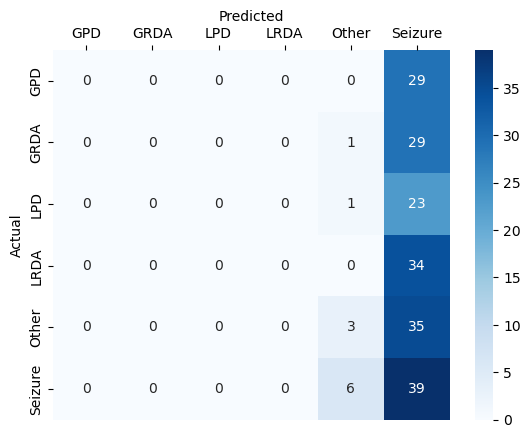

In [35]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm

clf = svm.SVC(decision_function_shape='ovo')
# clf = svm.LinearSVC(dual="auto")
clf.fit(X_train, y_train)
y_pred_svm = clf.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, average='weighted')
recall = recall_score(y_test, y_pred_svm, average='weighted')
f1 = f1_score(y_test, y_pred_svm, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
cm_df = pd.DataFrame(cm)
cm_df.columns = le.inverse_transform([0,1,2,3,4,5]).tolist()
cm_df.index = le.inverse_transform([0,1,2,3,4,5]).tolist()

hm = sns.heatmap(cm_df, annot=True, cmap='Blues')
hm.set_xlabel('Predicted')
hm.set_ylabel('Actual')
hm.xaxis.set_label_position('top')
hm.xaxis.tick_top()



Accuracy: 0.27
Precision: 0.27362232285831606
Recall: 0.27
F1 Score: 0.2705379680084736


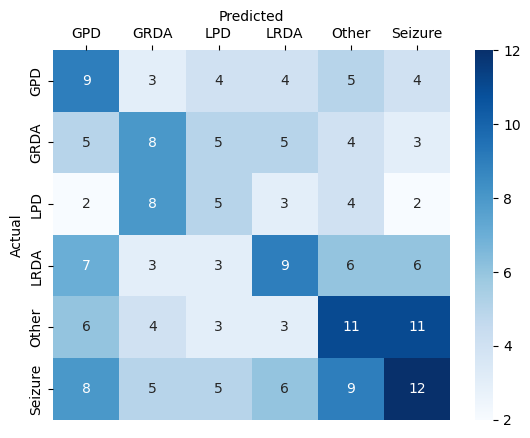

In [38]:
from sklearn import tree


clf_tree = tree.DecisionTreeClassifier()
# clf_tree = tree.DecisionTreeRegressor()

clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree, average='weighted')
recall = recall_score(y_test, y_pred_tree, average='weighted')
f1 = f1_score(y_test, y_pred_tree, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tree)
cm_df = pd.DataFrame(cm)
cm_df.columns = le.inverse_transform([0,1,2,3,4,5]).tolist()
cm_df.index = le.inverse_transform([0,1,2,3,4,5]).tolist()

hm = sns.heatmap(cm_df, annot=True, cmap='Blues')
hm.set_xlabel('Predicted')
hm.set_ylabel('Actual')
hm.xaxis.set_label_position('top')
hm.xaxis.tick_top()


Accuracy: 0.23
Precision: 0.2264950326466284
Recall: 0.23
F1 Score: 0.22421845621038247


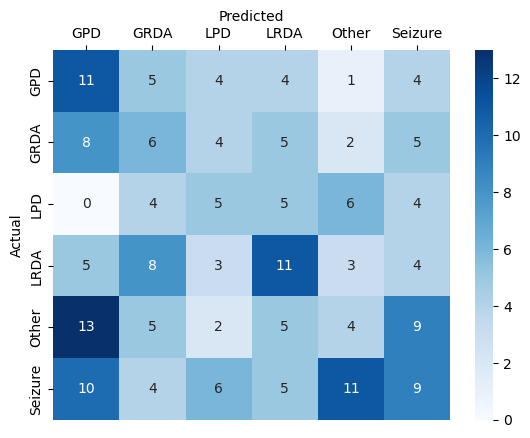

In [30]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=1)
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn, average='weighted')
recall = recall_score(y_test, y_pred_knn, average='weighted')
f1 = f1_score(y_test, y_pred_knn, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)
cm_df = pd.DataFrame(cm)
cm_df.columns = le.inverse_transform([0,1,2,3,4,5]).tolist()
cm_df.index = le.inverse_transform([0,1,2,3,4,5]).tolist()

hm = sns.heatmap(cm_df, annot=True, cmap='Blues')
hm.set_xlabel('Predicted')
hm.set_ylabel('Actual')
hm.xaxis.set_label_position('top')
hm.xaxis.tick_top()

Accuracy: 0.24
Precision: 0.09850041339396447
Recall: 0.24
F1 Score: 0.13941615541922292


/opt/anaconda3/envs/340-project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


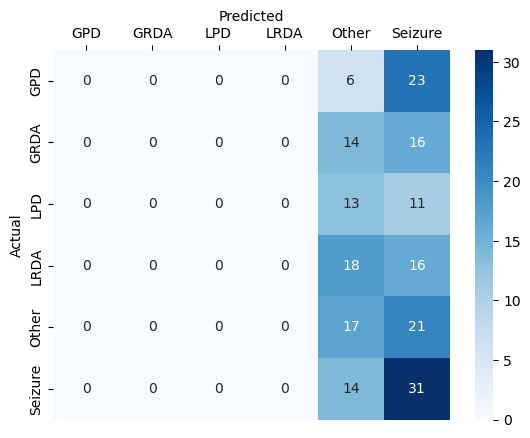

In [17]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state=0)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr, average='weighted')
recall = recall_score(y_test, y_pred_lr, average='weighted')
f1 = f1_score(y_test, y_pred_lr, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
cm_df = pd.DataFrame(cm)
cm_df.columns = le.inverse_transform([0,1,2,3,4,5]).tolist()
cm_df.index = le.inverse_transform([0,1,2,3,4,5]).tolist()

hm = sns.heatmap(cm_df, annot=True, cmap='Blues')
hm.set_xlabel('Predicted')
hm.set_ylabel('Actual')
hm.xaxis.set_label_position('top')
hm.xaxis.tick_top()

In [ ]:
# df_model = pd.DataFrame()
# for idx, row in top_channels_df.iterrows():
#   temp = df.loc[idx]
#   selected_columns = temp[["Fp1", "O2", "Fp2", "O1"]]
#   df_model = pd.concat([df_model, selected_columns])
# df_model

In [ ]:
# from sklearn.model_selection import train_test_split

# # Drop the column with NaN values
# # Transform the DataFrame into a 3D array
# n_features = 4  # Number of EEG channels used
# time_steps = 10000  # Rows per id
# n_sequences = len(df_model) // time_steps  # Total number of sequences

# # Initialize an empty array for the transformed data
# X = np.empty((n_sequences, time_steps, n_features))

# # Fill the array with data from the DataFrame
# for i, (idx, group) in enumerate(df_model.groupby('id')):
#     X[i] = group[['Fp1', 'O2', 'Fp2', 'O1']].values

# y = metadata.expert_consensus
# y = y.apply(lambda x: 1 if x == 'Seizure' else 0)

# # Split the data into training and test sets
# X_train = X[:400]
# y_train = y[:400]
# X_test = X[800:]
# y_test = y[800:]
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)


In [ ]:
# import torch
# import torch.nn as nn

# class LSTMModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
#         super(LSTMModel, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
        
#         # LSTM Layer
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
#         # Fully connected layer
#         self.fc = nn.Linear(hidden_dim, output_dim)
        
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
#         # Forward propagate LSTM
#         out, _ = self.lstm(x, (h0, c0))
        
#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         return torch.sigmoid(out)

# # Model initialization
# input_dim = 4  # Number of channels
# hidden_dim = 128  # Number of hidden units
# num_layers = 2  # Number of LSTM layers

# model = LSTMModel(input_dim, hidden_dim, output_dim=1, num_layers=num_layers)


In [ ]:
# from torch.utils.data import TensorDataset, DataLoader

# # Ensure X_train, X_test, y_train, y_test are all numpy arrays before proceeding
# X_train = X_train.values if isinstance(X_train, pd.Series) else X_train
# X_test = X_test.values if isinstance(X_test, pd.Series) else X_test
# y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
# y_test = y_test.values if isinstance(y_test, pd.Series) else y_test

# # Now, convert them into tensors
# train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
# test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

# # DataLoader
# batch_size = 64
# train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
# test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = LSTMModel(input_dim=4, hidden_dim=128, output_dim=1, num_layers=2).to(device)
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# num_epochs = 10
# criterion = nn.BCEWithLogitsLoss()
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
    
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs.squeeze(), labels)
        
#         # Backward and optimize
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [ ]:
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         predicted = (outputs.squeeze() > 0.5).float()
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# print(f'Accuracy: {100 * correct / total}')